# SEITR 数学建模描述疾病传播及病毒起始时间溯源

### 研究背景
- COVID-19 是一种由新型冠状病毒引起的急性呼吸道传染病，危重症可对患者生命 造成严重威胁，自 2019 年爆发首次疫情以来，新冠肺炎在世界各地的传播受到广泛关 注，并且已具备全球大流行特征。在高效的治疗手段和完全有效的疫苗出现之前，疫情的大规模流行将对人们的生命健康、日常生活和社会发展造成严重影响。因此，采取有效防控措施防止疫情在社会网络中大规模传播具有重要意义。 
- 控制疾病传染源是阻止疫情扩散最有效的措施，目前针对疫情传播溯源的方法主要有基因组测序和社会面流行病学调查两种方法。但由于 COVID-19 潜伏期长的特性，疾病隐匿流行的时间较长，导致仅仅通过调查表现出症状的患病者难以追溯到传染源，极大地增加了流调工作的繁琐程度。要在短时间内对爆发的疫情进行有效控制，必须快速确定传染源出现的大致时间区间，以辅助传统流调溯源工作的进行。本文通过易于获取的直观统计数据建立了一个能够表达现阶段常规化防控状态下小规模爆发疫情的仿真传播动力学模型，对疫情的源头进行时间维度上的溯源。

### 研究目标
- 通过构建舱室模型对传播的细节进行刻画
- 由模型辅助研究病毒在隐匿传播期的特点，从而对预测及控制提供参考

### 研究方法
- 基于平均场理论的舱室传播模型进行数据刻画
- 结合网络结构对模型的传播行为进行讨论

### 本笔记大纲
#### 1. 平均场SEITR模型及病毒起始时间溯源
#### 2. 网络结构上的SEITR及其对溯源时间的影响

 # 1. 平均场SEITR模型及病毒起始时间溯源

### 1.1模型介绍
- 将研究人群划分成5个仓室：易感者（Susceptible，S）、潜伏者（Exposed，E）、感染者（Infections，I）、检测阳者（Tested，T）、康复者（Removed，R），构建Susceptible-Exposed-Infections-Tested-Removed（SEITR）动力学模型。

- 其中易感者S接触到潜伏者E或感染者I会被感染转变为潜伏者E。其中易感者S接触到潜伏者E并被感染为E的概率为betaE，易感者S接触到感染者I并被感染为I的概率为betaI。
- 值得注意的是，在潜伏期E的感染者部分表现为无症状感染者，即新冠病毒核酸检测呈阳性，但目前没有明显症状。无症状感染者如果核酸检测呈阳性并已经出现症状，或者观察一段时间后出现咳嗽、发热、乏力等症状，就会被诊断为确诊病例。Ling et al. (2020) 研究发现个体从感染到出现症状或可以在喉咙样本中可检测到病毒后平均需要9.5天。模型中我们考虑σ为疾病的潜伏期的倒数。这类无症状感染者在潜伏期内转化成感染者的概率约为13.05%[http://k.sina.com.cn/article_1653603955_628ffe7301901auay.html]。而在潜伏期内没有转为感染者的潜伏者会自行康复。在模型中取值α=0.13。
- 在疫情常态化管控下，定期核酸检测会检测出群体中的无症状感染者与确诊患者并且将其隔离转运强制封闭。在模型中考虑在常规检测力度p的监控下会检测出阳性潜伏者与感染者并将其隔离。受到病毒潜伏期间检测可能无法准确的影响，并不是所有潜伏者都可以被及时检测出来。而对于感染者，其核酸检测呈阳性并已经出现症状，在日常核酸筛查的期间ω可以被检测并且隔离，目前通常采取的措施是三天一次的核酸检测频率。
- 对于突然爆发的局部疫情，管控力度会升级，局部静态管控，禁止人员流动等措施的实施会极大的降低病毒的传染能力。模型中我们考虑管控力度c，直接作用于病毒的感染率，模拟对管控措施的调整。

In [2]:
import networkx as nx
import matplotlib.pyplot as plot
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.integrate import odeint
import matplotlib.dates as mdate

In [3]:
# population
N = 1300*10**4
# simuation Time / Day
T = 200
# susceptiable ratio
s = np.zeros([T])
# exposed ratio
e = np.zeros([T])
# infective ratio
i = np.zeros([T])
# tested ratio
te = np.zeros([T])
# remove ratio
r = np.zeros([T])

#基本再生数
r0 = 12

# recover rate
gamma = 1/14

# contact rate
#确诊病例的密切接触者感染率为6.3%，无症状感染者的密切接触者感染率为4.11%。 https://www.dahebao.cn/news/1516380?cid=1516380
betae = r0*gamma
betai = r0*gamma


# 潜伏期
# exposed period
incubation = 9.5

#潜伏期转移
#http://k.sina.com.cn/article_1653603955_628ffe7301901auay.html 
alpha = 0.13

#*****************可调控参数*********************
#核酸检测窗口
w = 1/3*0 

#检测力度
p = 0.6

#接触能力
c = 1

#静态管控时长
control_time = 7


#初始感染情况 initial infective people
i[0] = 1 / N
s[0] = (N-1) / N
e[0] = 0 / N
te[0] = 0 /N

for t in range(T-1):  
#     if te.sum() * N > 18 and control_time > 0:
#         c=0
#         p=0.9
#         control_time-=1
#     elif control_time ==0 :
#         c=0
#         p=0.8     
#     else:#initial condition
#         c = 1
#         p = 0.6
    s[t + 1] = s[t] - c * betai * s[t] * i[t]  - c * betae * s[t] * e[t] 
    e[t + 1] = e[t] + c * betai * s[t] * i[t] + c * betae * s[t] * e[t]  - 1/incubation * alpha * e[t] - 1/incubation * (1 - alpha) * e[t] - 1/incubation * w * p * e[t]
    i[t + 1] = i[t] + 1/incubation * alpha * e[t] - gamma * i[t] - w * p * i[t] 
    te[t + 1] = te[t] + w * p * i[t] + 1/incubation * w * p * e[t]
    r[t + 1] = r[t] + 1/incubation * (1 - alpha) * e[t] + gamma * i[t] #+ w * p * i[t] + 1/incubation * p * e[t]

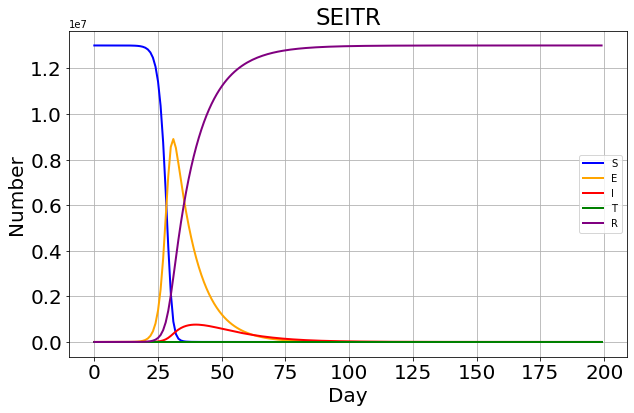

In [4]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(s*N, c='b', lw=2, label='S')
ax.plot(e*N, c='orange', lw=2, label='E')
ax.plot(i*N, c='r', lw=2, label='I')
ax.plot(te*N, c='g', lw=2, label='T')
ax.plot(r*N, c='purple', lw=2, label='R')
ax.set_xlabel('Day',fontsize=20)
ax.set_ylabel('Number', fontsize=20)
ax.grid(1)
plt.title('SEITR',fontsize = 23)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend();

- 添加平均场公式以及状态转移图
- 以上是基于平均场理论SEITR数值模拟结果

### 1.2 结合真实数据的SEITR对照

#### 西安疫情数据 8.9-9.18 共计40天

In [5]:
import pandas as pd

excel_data = pd.read_excel('西安7月-9月疫情数据.xlsx')
data = pd.DataFrame(excel_data, columns=['日期', '新增', '新增无症状'])
data['当日新增'] = data.loc[:,['新增','新增无症状']].sum(axis=1)
aug_data = data.iloc[40:80]
aug_data.reset_index(drop=True, inplace=True)
aug_data['累计新增'] = aug_data['当日新增'].cumsum()

/var/folders/rz/q545n5f15gz3jyrtnk4qt5l00000gn/T/ipykernel_33716/4230061285.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aug_data['累计新增'] = aug_data['当日新增'].cumsum()


/var/folders/rz/q545n5f15gz3jyrtnk4qt5l00000gn/T/ipykernel_33716/703358470.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aug_data['日期'] = pd.to_datetime(aug_data['日期'])    #轉換為日期，否則下面的日期設置不會生效


[None]

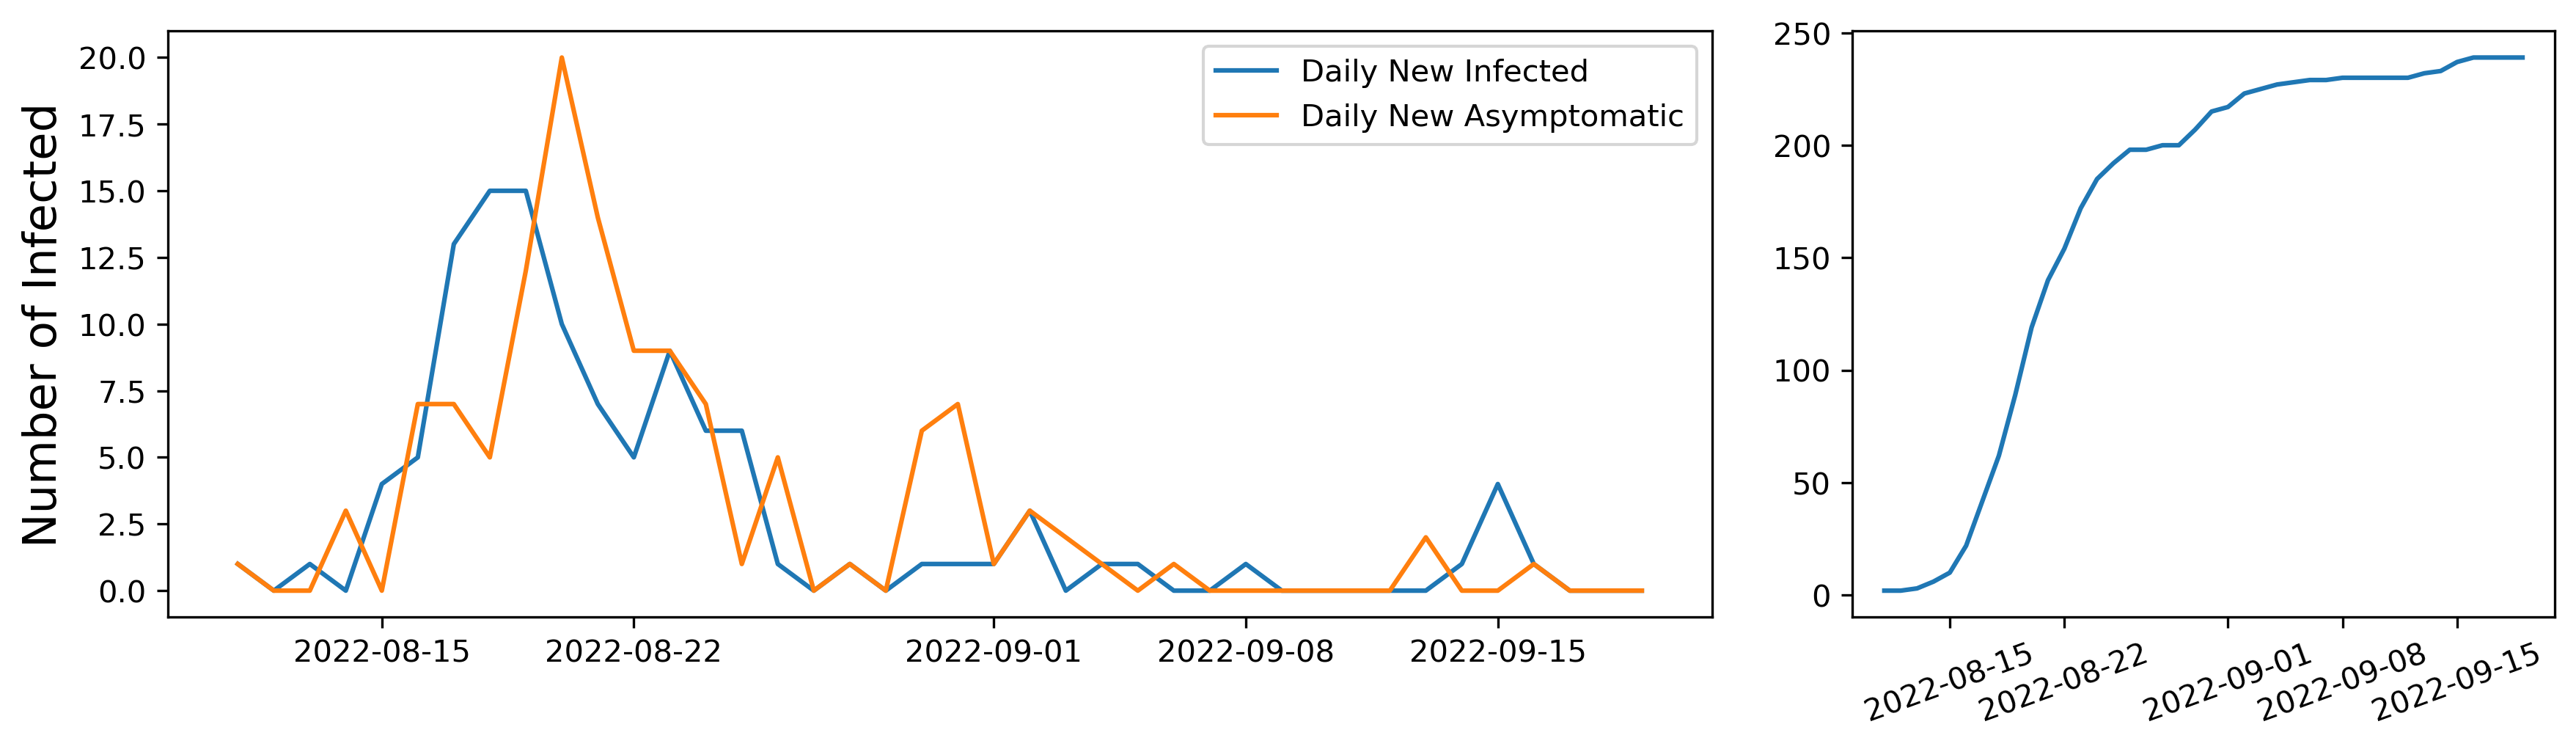

In [6]:
aug_data['日期'] = pd.to_datetime(aug_data['日期'])    #轉換為日期，否則下面的日期設置不會生效
aug_data = aug_data.set_index(aug_data['日期'])
# fig = plt.figure(figsize=(20, 5))
# ax = fig.add_subplot(1, 2, 1)
plt.figure(figsize=(14, 12), dpi=300)
ax=plt.subplot2grid((3,3),(1,0),colspan=2,rowspan=1)
ax.set(facecolor = "white")
plt.plot(aug_data['新增'],label = 'Daily New Infected')
plt.plot(aug_data['新增无症状'],label = 'Daily New Asymptomatic')
# ax.set_xlabel('Day',fontsize=20)
ax.set_ylabel('Number of Infected', fontsize=15)
# plt.title('Xian Auguest Daily New Case Data',fontsize = 15)
plt.legend(facecolor = "white")
ax.set(facecolor = "white")
ax=plt.subplot2grid((3,3),(1,2),colspan=1,rowspan=1)

plt.plot(np.cumsum(aug_data['新增']+aug_data['新增无症状']))
ax.set(facecolor = "white")
#ax.set_ylabel('Number of Infected', fontsize=12)
plt.xticks(rotation=20)
ax.set(facecolor = "white")
# plt.title('Accumulated Daily New Case',fontsize = 15)

In [7]:
aug_data.head(10)

,日期,新增,新增无症状,当日新增,累计新增
日期,,,,,
2022-08-11,2022-08-11,1,1,2,2
2022-08-12,2022-08-12,0,0,0,2
2022-08-13,2022-08-13,1,0,1,3
2022-08-14,2022-08-14,0,3,3,6
2022-08-15,2022-08-15,4,0,4,10
2022-08-16,2022-08-16,5,7,12,22
2022-08-17,2022-08-17,13,7,20,42
2022-08-18,2022-08-18,15,5,20,62
2022-08-19,2022-08-19,15,12,27,89


#### NOTE:
- 由于基于平均场理论近似求解方程得到的是唯一稳定解，不存在波动，曲线较为平滑
- 我们可以将次作为病毒起始时间溯源工作的基准，对后续结合网络结构的SEITR进行蒙卡仿真的波动进行对照推断可能的溯源结果

In [8]:
# population
N = 1300*10**4
# simuation Time / Day
T = 50
# susceptiable ratio
s = np.zeros([T])
# exposed ratio
e = np.zeros([T])
# infective ratio
i = np.zeros([T])
# tested ratio
te = np.zeros([T])
# remove ratio
r = np.zeros([T])

growth = np.zeros([T])

#基本再生数
r0 = 12

# recover rate
gamma = 1/14

# contact rate
#确诊病例的密切接触者感染率为6.3%，无症状感染者的密切接触者感染率为4.11%。 https://www.dahebao.cn/news/1516380?cid=1516380
betae = r0*gamma
betai = r0*gamma

# 潜伏期
# exposed period
incubation = 9.5

#潜伏期转移
#http://k.sina.com.cn/article_1653603955_628ffe7301901auay.html 
alpha = 0.13

#*****************可调控参数*********************
#核酸检测窗口
w = 1/3 

#检测力度
p = 0.8

#接触能力
c = 1

#静态管控时长
control_time = 300


#初始感染情况 initial infective people
i[0] = 1 / N
s[0] = (N-1) / N
e[0] = 0 / N
te[0] = 0 /N

for t in range(T-1):  
    if te.sum() * N > 40 and control_time > 0:
        c=0
        p=0.99
        w=1
        control_time-=1
#     elif control_time ==0 :
#         c=0
#         p=0.8     
    else:#initial condition
        c = 1
        p = 0.8
        w= 1/3
    s[t + 1] = s[t] - c * betai * s[t] * i[t]  - c * betae * s[t] * e[t] 
    e[t + 1] = e[t] + c * betai * s[t] * i[t] + c * betae * s[t] * e[t]  - 1/incubation * alpha * e[t] - 1/incubation * (1 - alpha) * e[t] - 1/incubation * w * p * e[t]
    i[t + 1] = i[t] + 1/incubation * alpha * e[t] - gamma * i[t] - w * p * i[t] 
    te[t + 1] = te[t] + w * p * i[t] + 1/incubation * w * p * e[t]
    r[t + 1] = r[t] + 1/incubation * (1 - alpha) * e[t] + gamma * i[t] #+ w * p * i[t] + 1/incubation * p * e[t]
    growth[t+1]=te[t + 1]-te[t]

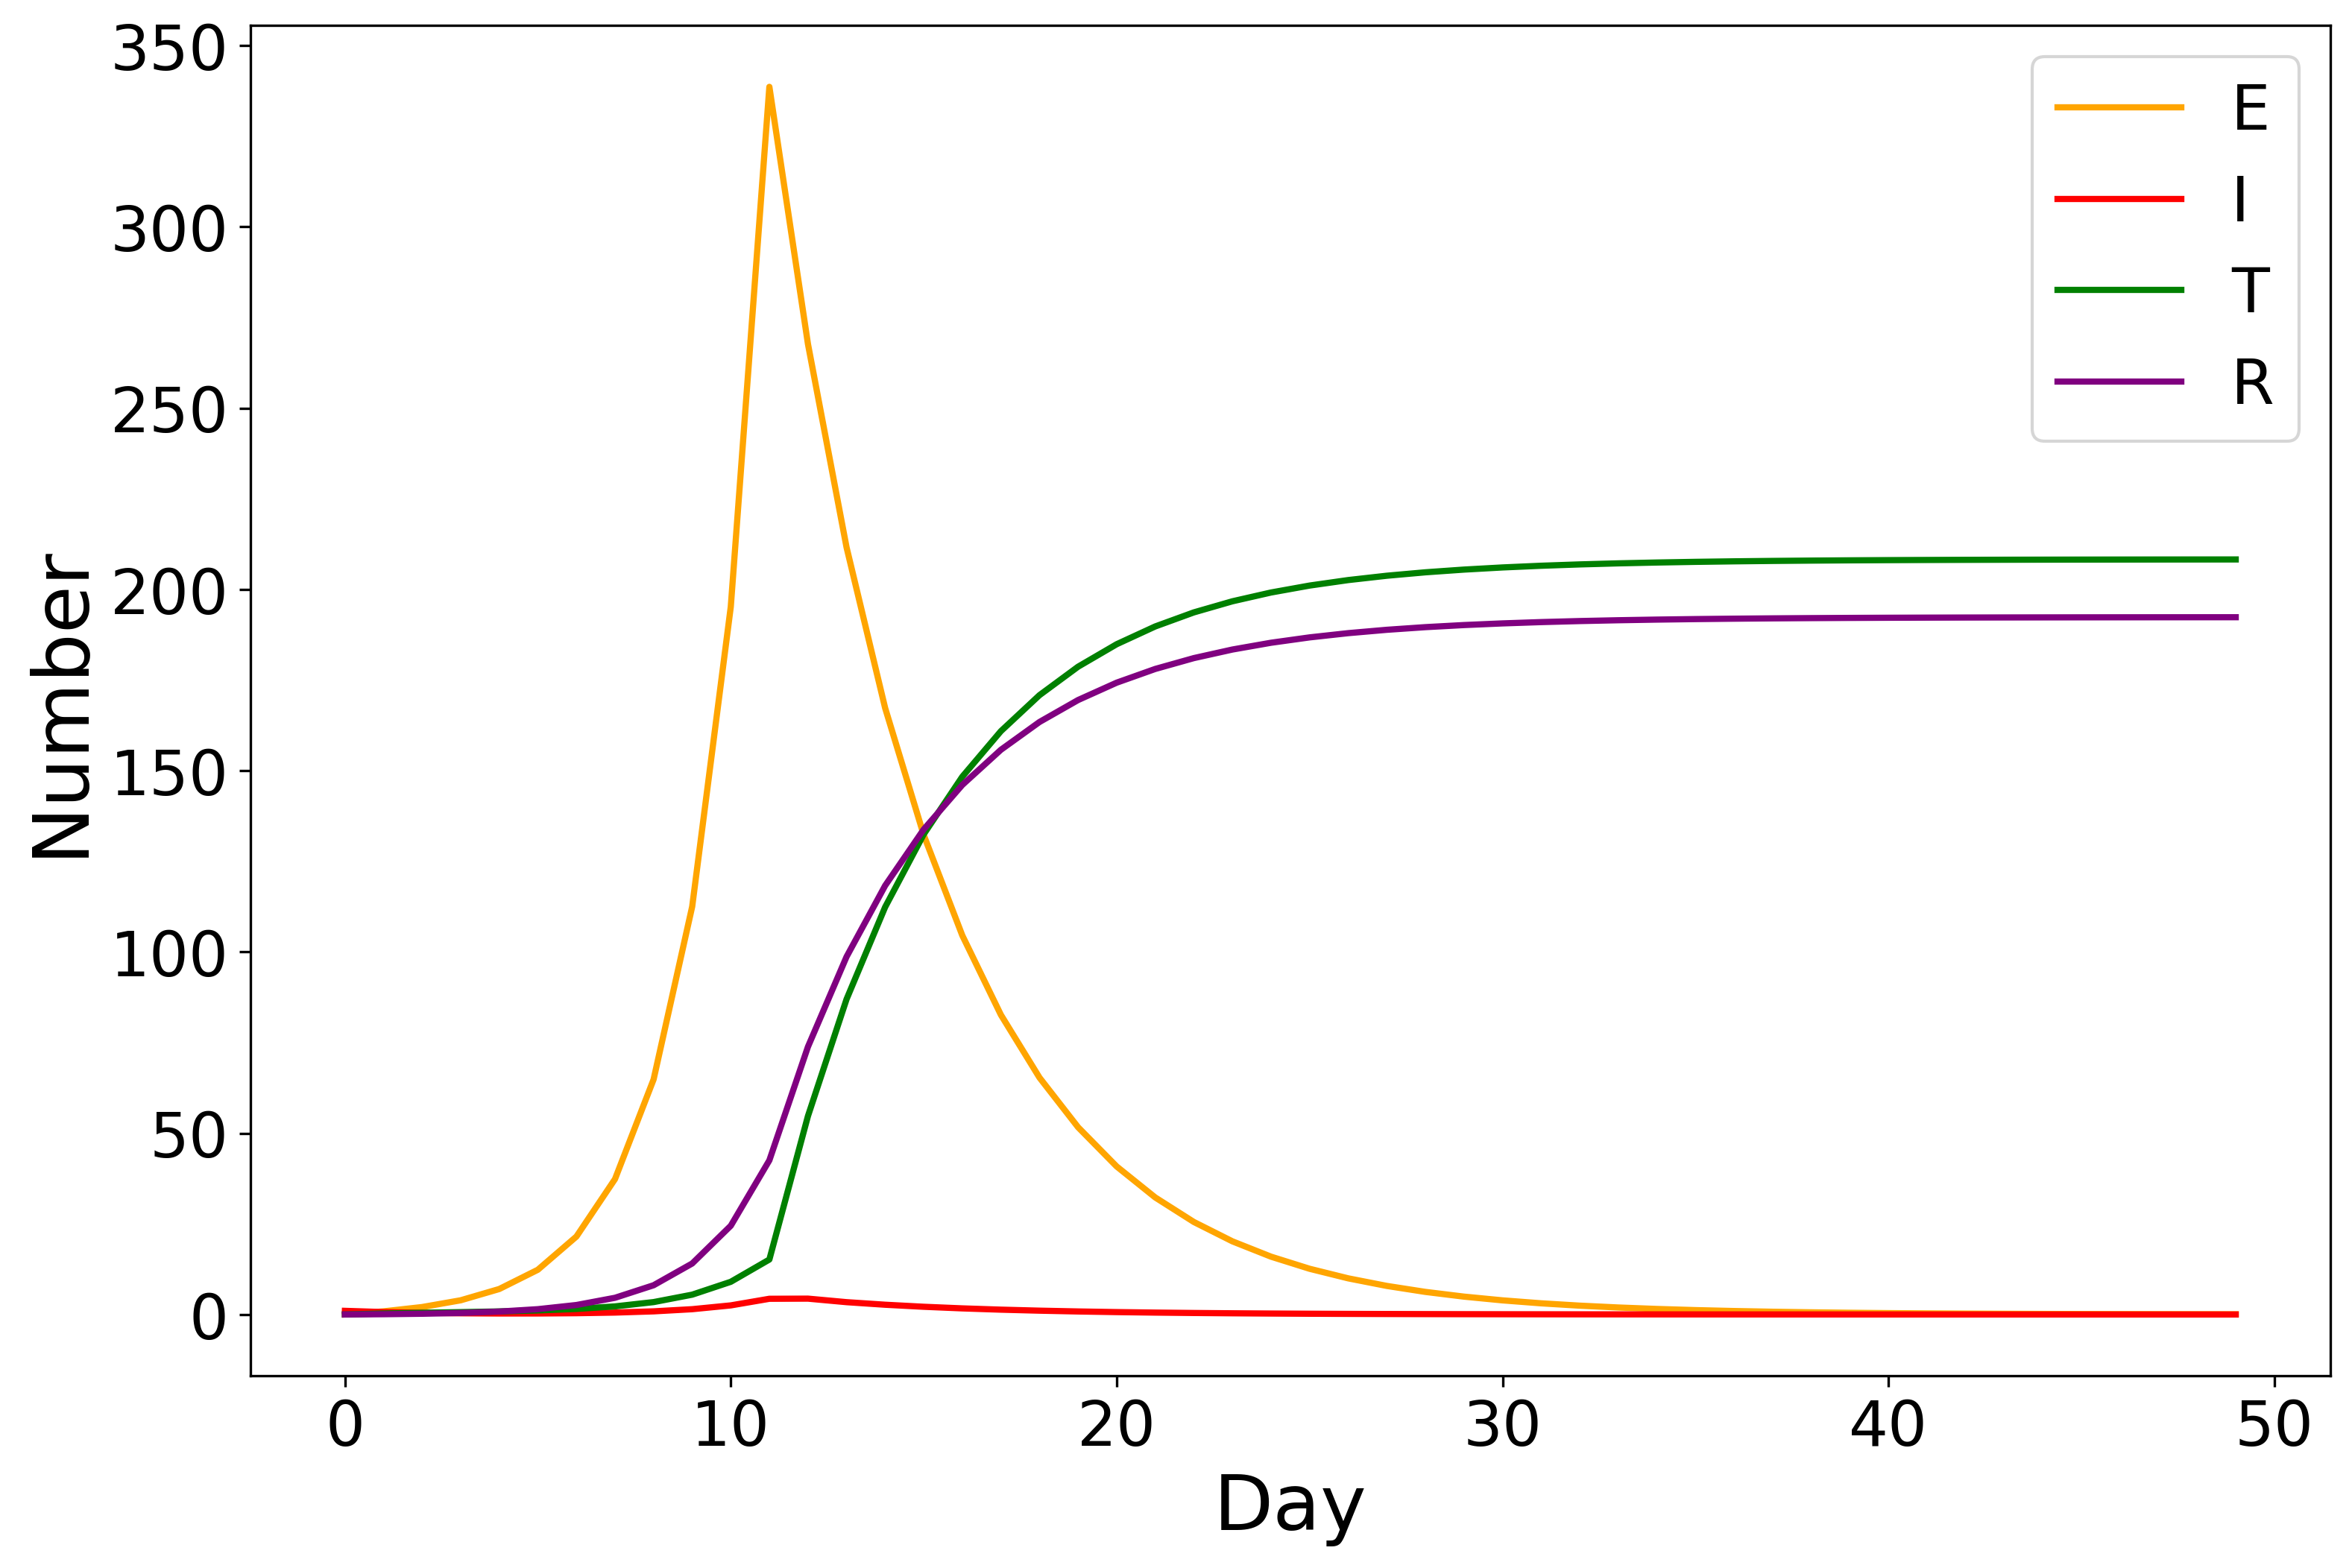

In [9]:
fig, ax = plt.subplots(figsize=(12,8), dpi=300)
# ax.plot(s*N, c='b', lw=2, label='S')
ax.plot(e*N, c='orange', lw=2, label='E')
ax.plot(i*N, c='r', lw=2, label='I')
ax.plot(te*N, c='g', lw=2, label='T')
ax.plot(r*N, c='purple', lw=2, label='R')
ax.set_xlabel('Day',fontsize=25)
ax.set_ylabel('Number', fontsize=25)
# ax.grid(1)
# plt.title('SEITR with Lockdown',fontsize = 23)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);

### 寻找最佳溯源结果

In [10]:
df = pd.DataFrame()
sim=growth*N
df['模拟']=sim.tolist()
df['溯源']=0

In [11]:
trace_res = pd.DataFrame()
trace_day = []
trace_error = []
for tt in range(0,10):
    trace_day.append(tt)
    trace = tt
    add_source = [0]*trace+aug_data['当日新增'].tolist()
    df['溯源'][:len(add_source)] = add_source
    error = sum(abs(df['溯源'][:len(sim)]-df['模拟'])/len(df))
    trace_error.append(error)

/var/folders/rz/q545n5f15gz3jyrtnk4qt5l00000gn/T/ipykernel_33716/1022333035.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['溯源'][:len(add_source)] = add_source


In [12]:
trace_res['Trace Time']=trace_day
trace_res['Culculate Error']=trace_error
trace_res

,Trace Time,Culculate Error
0,0,5.434314
1,1,5.006452
2,2,4.328424
3,3,3.279302
4,4,2.433664
5,5,2.215451
6,6,2.298165
7,7,2.926730
8,8,3.645776
9,9,4.375335


In [13]:
best_trace=5

### 全局的对照以及起始时间追溯

In [14]:
best_trace = 5
add_source = [0]*best_trace+aug_data['累计新增'].tolist()
error = max(abs(add_source-te[:len(add_source)]*N))

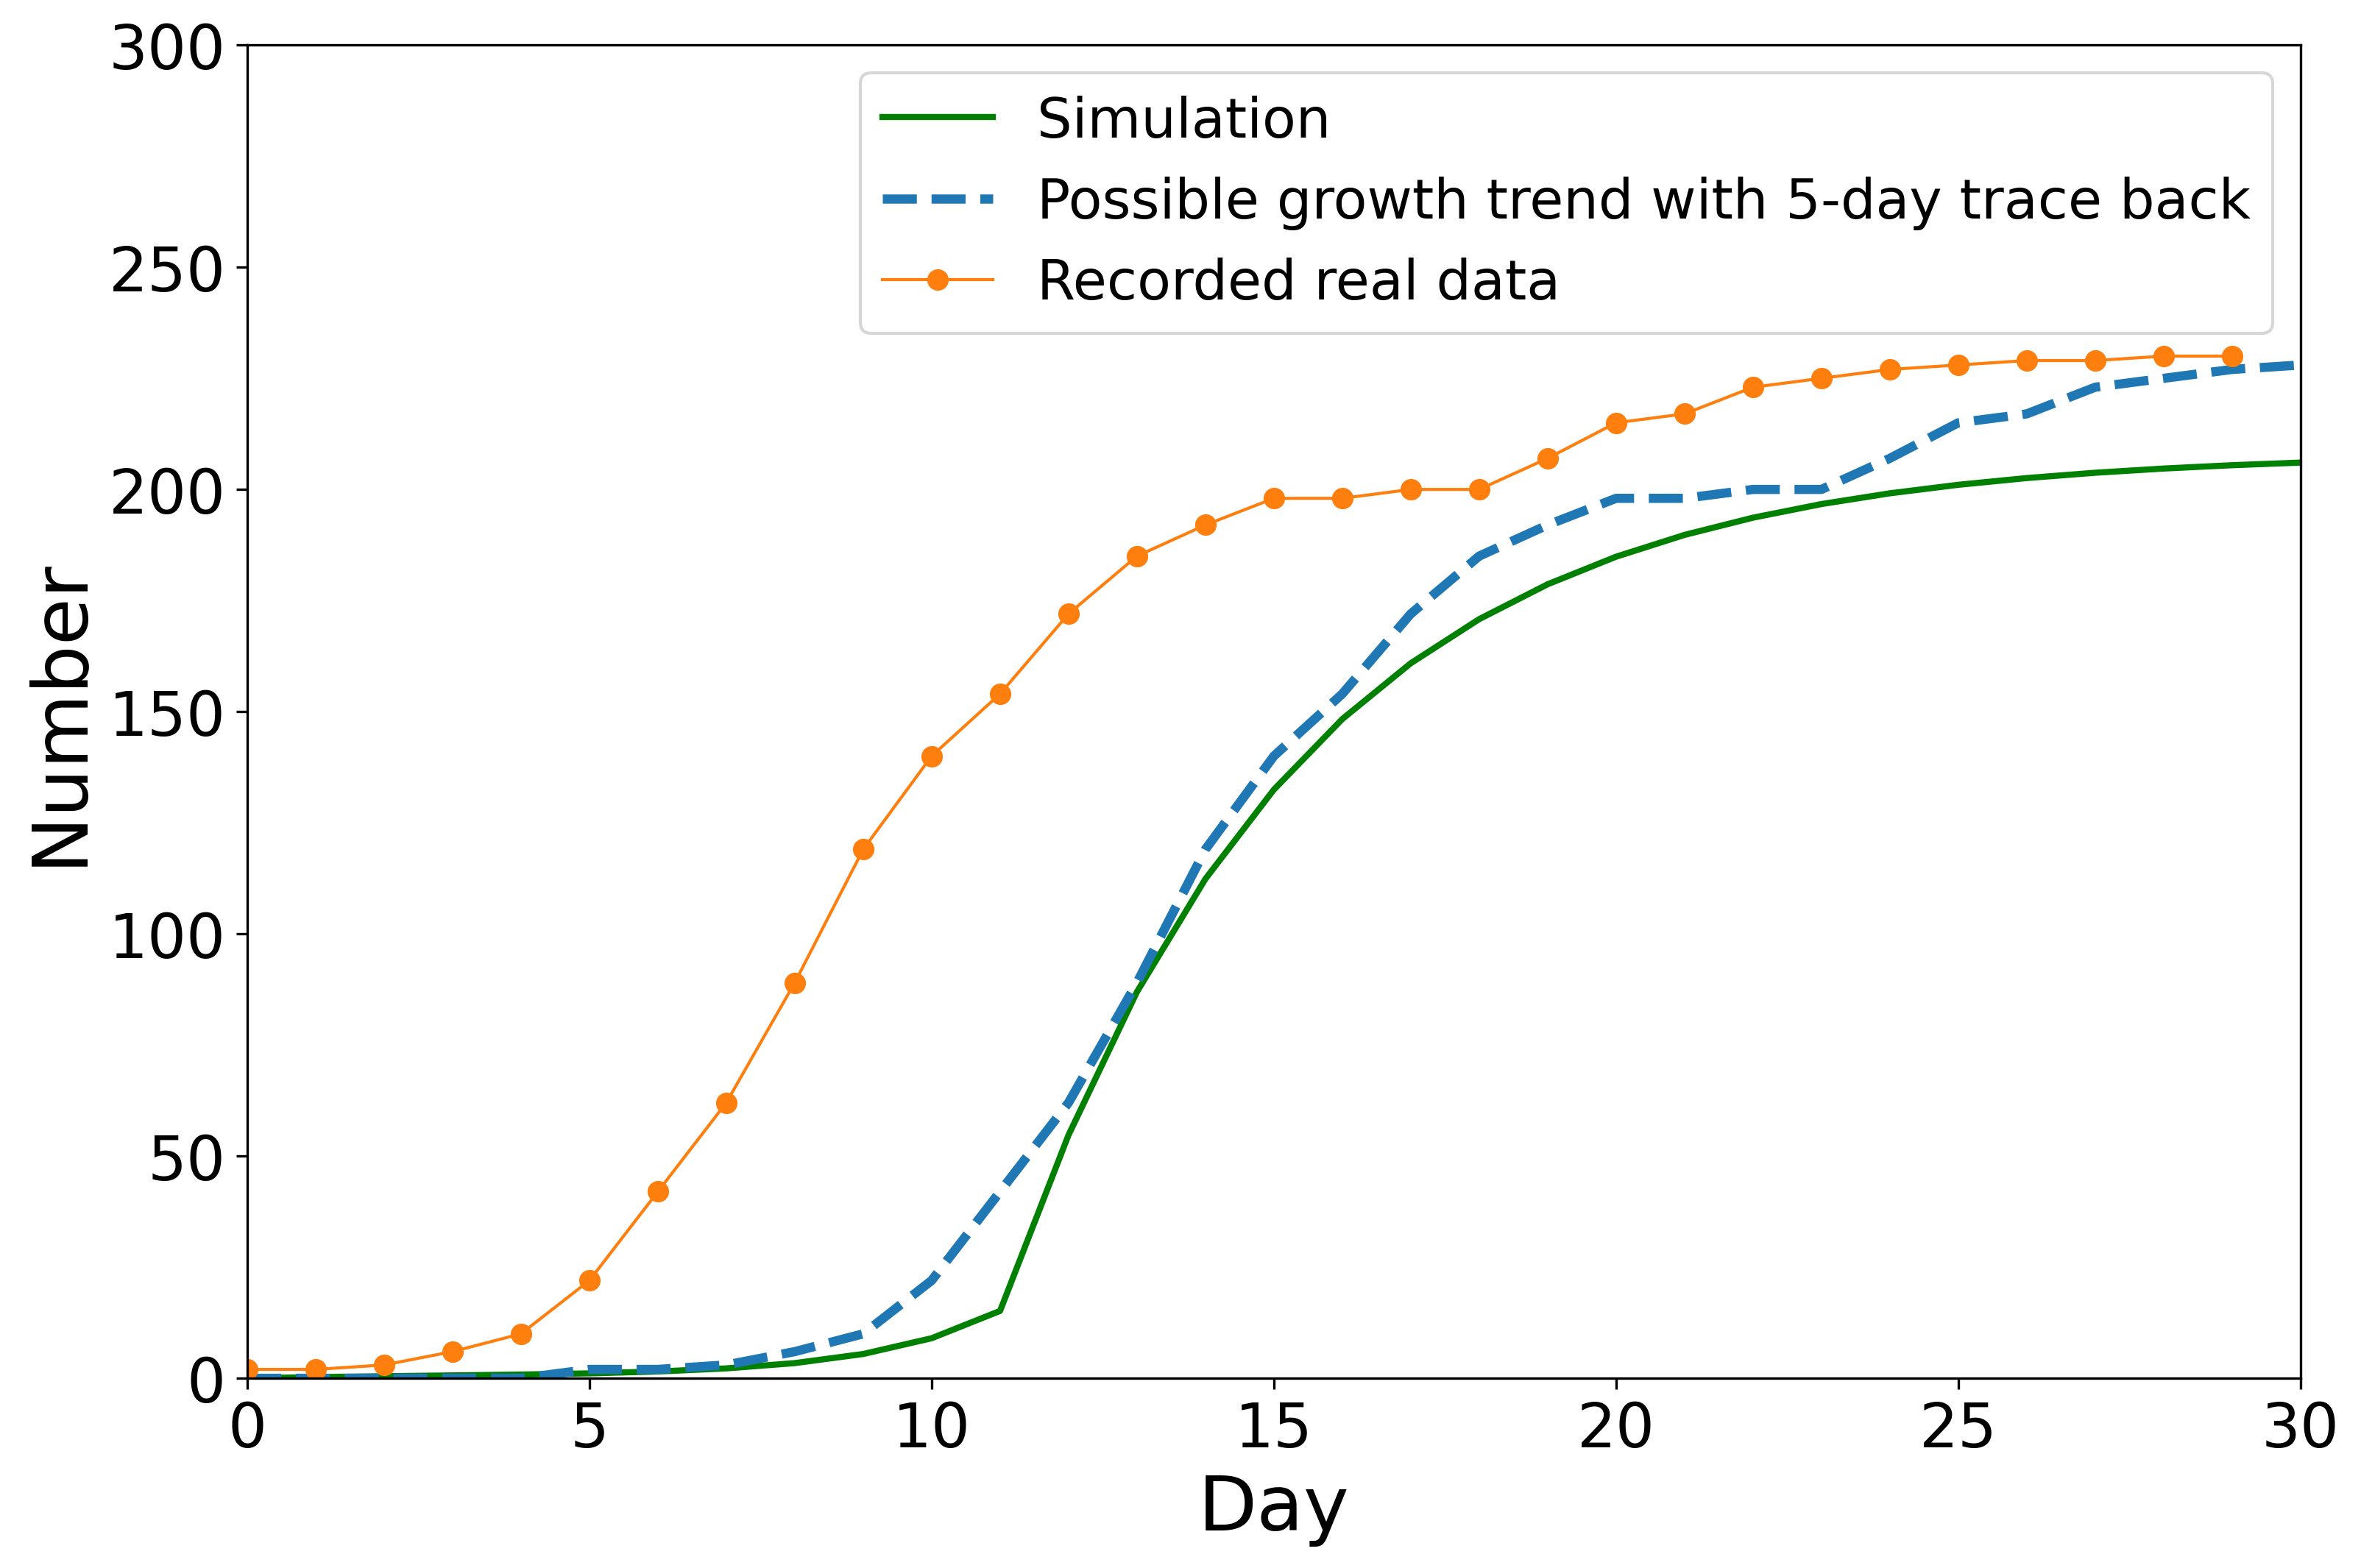

In [15]:
fig, ax = plt.subplots(figsize=(12,8), dpi=300)
ax.plot(te[:len(add_source)]*N, c='g', lw=2, label='Simulation')
plt.plot(add_source,ls='--',lw=3, label = 'Possible growth trend with 5-day trace back')
aug_data.reset_index(drop=True, inplace=True)
plt.plot(aug_data['累计新增'][:30],marker='o',lw=1, label='Recorded real data')
ax.set_xlabel('Day',fontsize=25)
ax.set_ylabel('Number', fontsize=25)
ax.grid(0)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.title('5 Day Trace Back Considering Control Policy',fontsize = 23)

plt.ylim([0,300])
plt.xlim([0,30])
plt.legend(fontsize = 18);

In [16]:
simulation = pd.DataFrame()

In [17]:
simulation['te']=te[:len(add_source)+best_trace]*N
simulation['e']=e[:len(add_source)+best_trace]*N
simulation['i']=i[:len(add_source)+best_trace]*N
simulation['ind']=np.arange(-1*best_trace,len(simulation)-best_trace)

In [18]:
simulation=simulation.set_index('ind')

In [19]:
from matplotlib.offsetbox import AnchoredText

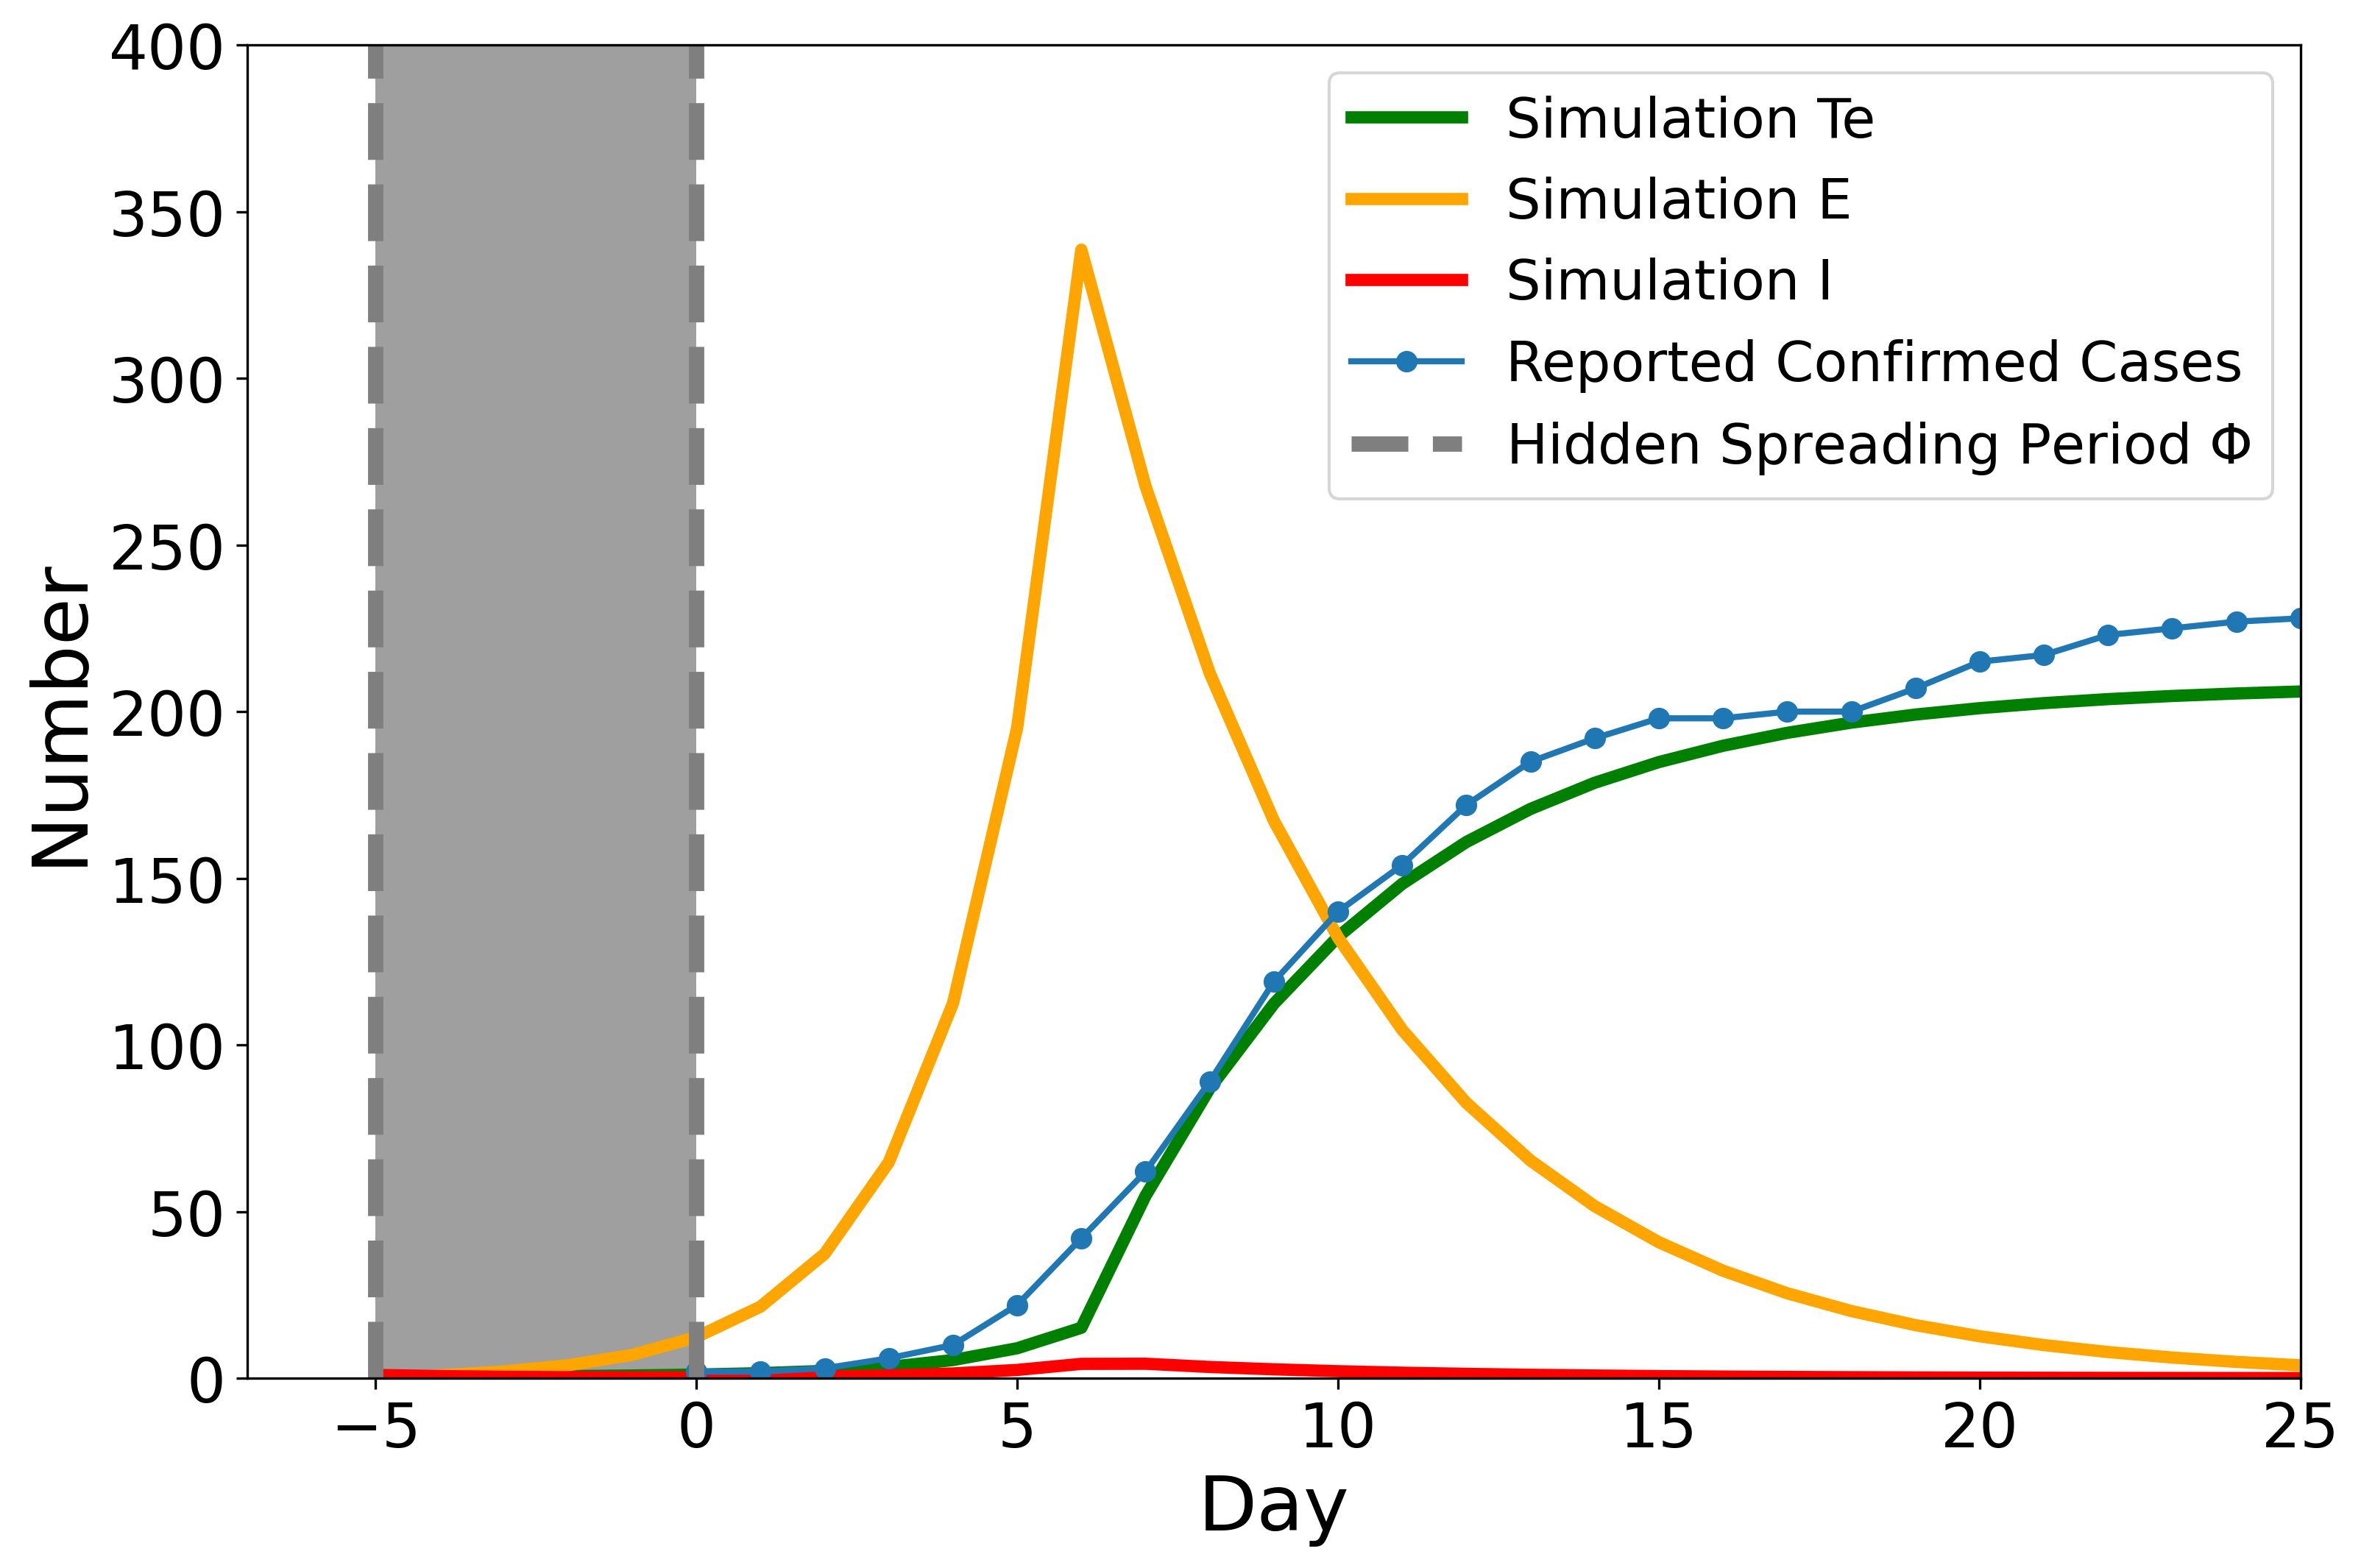

In [23]:
fig, ax = plt.subplots(figsize=(12,8), dpi=300)
ax.plot(simulation['te'],c='g', lw=4, label='Simulation Te')
ax.plot(simulation['e'], c='orange', lw=4, label='Simulation E')
ax.plot(simulation['i'], c='r', lw=4, label='Simulation I')


plt.plot(aug_data['累计新增'],marker='o',lw=2, label = 'Reported Confirmed Cases')
aug_data.reset_index(drop=True, inplace=True)
ax.set_xlabel('Day',fontsize=25)
ax.set_ylabel('Number', fontsize=25)
ax.grid(0)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.title('5 Day Trace Back Considering Control Policy',fontsize = 23)
x1 = -5
x2 = 0
plt.axvspan(x1, x2, color='C7', alpha=0.75, lw=0)
plt.axvline(x2,ls='--',lw=5,color='C7',label = 'Hidden Spreading Period $\Phi$')
plt.axvline(x1,ls='--',lw=5,color='C7')


# ann = ax.annotate("Started Hidden Spread",
#                   xy=(-5, 0), xycoords='data',
#                   xytext=(-3, 100), textcoords='data',
#                   size=15, va="baseline", ha="center",
#                   bbox=dict(boxstyle="round", fc="w"),
#                   arrowprops=dict(arrowstyle="simple",
#                             color="0",
#                             shrinkB=6,
#                             relpos=(0.1, 0.),
#                             connectionstyle="arc3,rad=-0.",
#                             ),
#                   )

# ann = ax.annotate("Reported First Case",
#                   xy=(0, 0), xycoords='data',
#                   xytext=(-1, 80), textcoords='data',
#                   size=15, va="center", ha="center",
#                   bbox=dict(boxstyle="round", fc="w"),
#                   arrowprops=dict(arrowstyle="simple",
#                             color="0",
#                             shrinkB=6,
#                             connectionstyle="arc3,rad=0.",
#                             ),
#                   )

plt.ylim([0,400])
plt.xlim([-7,25])
plt.legend(fontsize = 18);

#### Note:
- 最佳的fit的参数需要写明，值得注意的是p并不高这个与实际情况有出入
- 以及调控情况需要写清楚

### 如果只考虑疫情传播初始两周的情况，不考虑调控力度，检测力度对其影响

In [199]:
N = 1300*10**4
T = 14
s = np.zeros([T])
e = np.zeros([T])
i = np.zeros([T])
te = np.zeros([T])
r = np.zeros([T])
growth = np.zeros([T])
r0 = 12
gamma = 1/14
betae = r0*gamma
betai = r0*gamma
incubation = 9.5
alpha = 0.13

Text(0.5, 1.0, 'Testing Ability Comparison')

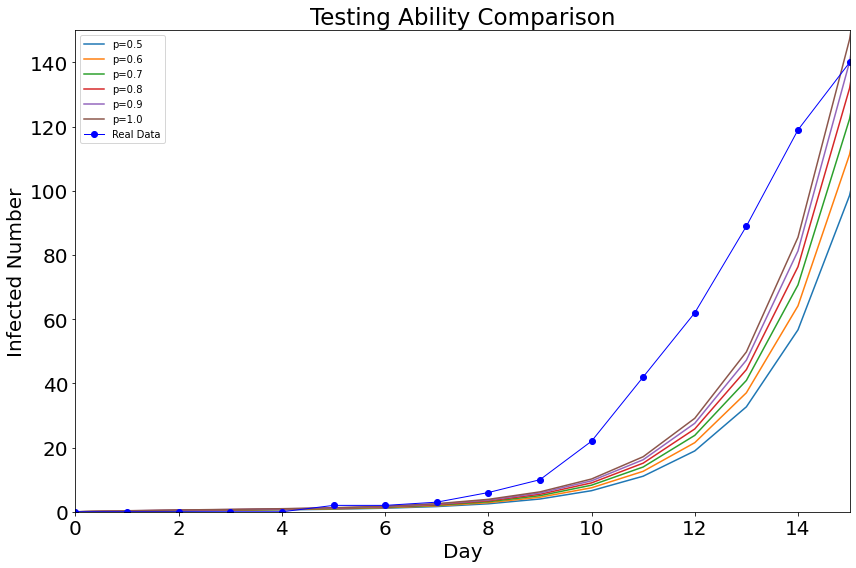

In [214]:
fig, ax = plt.subplots(figsize=(12,8))
for pp in np.linspace(0.5,1,6):

    #*****************可调控参数*********************
    #核酸检测窗口
    w = 1/3 
    #检测力度
    p = pp
    #接触能力
    c = 1
    #初始感染情况 initial infective people
    i[0] = 1 / N
    s[0] = (N-1) / N
    e[0] = 0 / N
    te[0] = 0 /N
    for t in range(T-1):  
        s[t + 1] = s[t] - c * betai * s[t] * i[t]  - c * betae * s[t] * e[t] 
        e[t + 1] = e[t] + c * betai * s[t] * i[t] + c * betae * s[t] * e[t]  - 1/incubation * alpha * e[t] - 1/incubation * (1 - alpha) * e[t] - 1/incubation * w * p * e[t]
        i[t + 1] = i[t] + 1/incubation * alpha * e[t] - gamma * i[t] - w * p * i[t] 
        te[t + 1] = te[t] + w * p * i[t] + 1/incubation * w * p * e[t]
        r[t + 1] = r[t] + 1/incubation * (1 - alpha) * e[t] + gamma * i[t] #+ w * p * i[t] + 1/incubation * p * e[t]
        growth[t+1]=te[t + 1]-te[t]
        
        
    plt.plot(te*N, label='p='+str(round(p,1)))
    
    ax.set_xlabel('Day',fontsize=20)
    ax.set_ylabel('Infected Number', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,150])
plt.xlim([0,15])
plt.plot(add_source,marker='o',lw=1,c='b',label = 'Real Data')
plt.legend()
plt.title('Testing Ability Comparison',fontsize = 23)
    

#### Note: 
- p 的大小对于新增的快慢有着直接关系
- 固定追溯5天调整检测力度对其的影响
- 并且我们看到0.5是一个不错的fit,下一步我们固定p=0.5

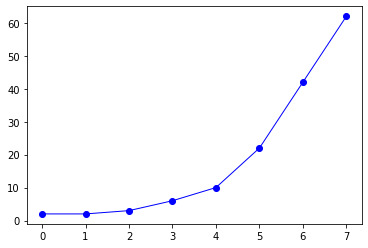

In [456]:
plt.plot(aug_data['累计新增'][:8],marker='o',lw=1,c='b',label = 'Real Data')

### 讨论

在真实数据中我们看到第5天时记录到累计10，第10天累计119。
- 有哪些因素会影响到病毒的传播速度？
- 在我们的模型中可以调解的参数主要有，检测力度p 以及管控力度c。而管控力度会直接影响到病毒的感染力，这背后有着多维的复杂的因素。
这些都是在对病毒进行溯源时需要考虑的因素。

In [454]:
aug_data.head(10)

,日期,新增,新增无症状,当日新增,累计新增
0,2022-08-11,1,1,2,2
1,2022-08-12,0,0,0,2
2,2022-08-13,1,0,1,3
3,2022-08-14,0,3,3,6
4,2022-08-15,4,0,4,10
5,2022-08-16,5,7,12,22
6,2022-08-17,13,7,20,42
7,2022-08-18,15,5,20,62
8,2022-08-19,15,12,27,89
9,2022-08-20,10,20,30,119


# 2. 网络结构上的SEITR及其对溯源时间的影响

In [457]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.integrate import odeint

In [633]:
def update_model(X,A,incubation,betae,betai,alpha,gamma,p,w,c):
    ID = np.arange(len(A))
    nX = X.copy()
    for i in range(len(X)):
        neighbor_ID = ID[A[i]>0]#寻找邻居
        if X[i] == 0:#suspectible 
            #统计邻居节点状态进行感染
            #计算有多少
            nume=0
            numi=0
            for ni in neighbor_ID:
                if X[ni] == 1:
                    #S碰到E，统计人数
                    nume+=1
                elif X[ni] == 2:
                    #S碰到I
                    numi+=1
            #根据现有多少个A和I来计算传播概率*管控力度
            if np.random.random()< c*(1-(1-betai)**numi*(1-betae)**nume):
                nX[i] = 1
        if X[i] == 1:#ecubate
            #以潜伏天数的倒数*一定感染概率alpha转为确诊，或被移除
            if np.random.random()< 1/incubation:
                if np.random.random()< alpha:
                    nX[i] = 2#i
                else:
                    nX[i] = 4#r
                #检测力度被检测出来
                if np.random.random()< p:
                    nX[i] = 3#t
        if X[i] == 2:#infected to tested or recover 
            if np.random.random()< w * p:
                nX[i] = 3#t
            if np.random.random() < gamma:
                nX[i] = 4      
    return nX
                    
    
def loop_model(X0,A,incubation,betae,betai,alpha,gamma,p,w,c,control_time):
    T = 30
    Xp = X0.copy()
    S = np.zeros(T)
    E = np.zeros(T)
    I = np.zeros(T)
    Te = np.zeros(T)
    R = np.zeros(T)
    
    S[0] = np.sum(X0==0)
    E[0] = np.sum(X0==1)
    I[0] = np.sum(X0==2)
    Te[0] = np.sum(X0==3)
    R[0] = np.sum(X0==4)
    
    for t in range(T-1):
#         if Te.sum() > 15 and control_time > 0:#发现病例累计18开始封控一周
#             c=0
#             p=0.99
#             w=1/3
#             control_time-=1#封控一周结束后直到没有新增
# #         elif control_time ==0:#封控一周结束后直到没有新增
# #             c=0.1
# #             p=0.88
# #             w=1/3
#         else:#initial condition
#             c = 1
#             p = 0.5
#             w=1/3

    
        nX = update_model(Xp,A,incubation,betae,betai,alpha,gamma,p,w,c)
        Xp = nX.copy()
        S[t+1] = np.sum(nX==0)
        E[t+1] = np.sum(nX==1)
        I[t+1] = np.sum(nX==2)
        Te[t+1] = np.sum(nX==3)
        R[t+1] = np.sum(nX==4)
    return S,E,I,Te,R,nX       

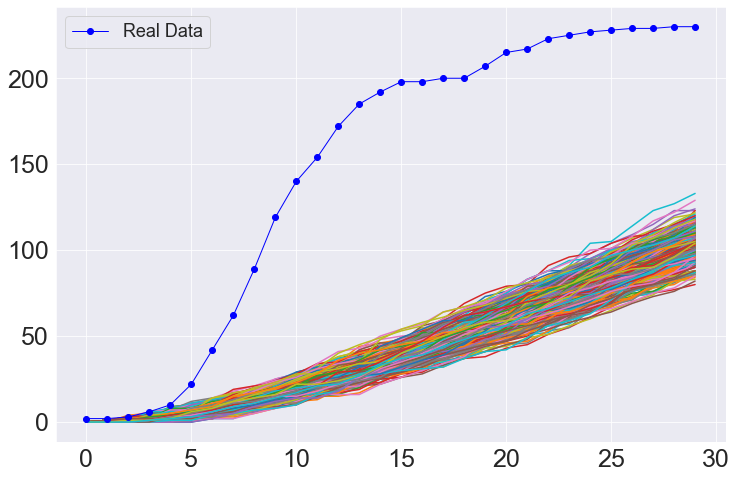

In [634]:
#初始条件
#初始网络
ws = nx.random_graphs.watts_strogatz_graph(500, 10, 0)
A = nx.to_numpy_array(ws)
# ba = nx.barabasi_albert_graph(500, 1)
# A = nx.to_numpy_array(ba)

r0 = 12
gamma = 1/14
betae = r0*gamma
betai = r0*gamma*6/4
incubation = 9.5
alpha = 0.13

#*****************可调控参数*********************
#核酸检测窗口
w = 1/3 

#检测力度
p = 0.5

#接触能力
c = 1

#静态管控时长
control_time = 300

X0 = np.zeros(len(A))
#seed spreader
X0[60] = 2
# X0[100] = 2
# X0[30] = 2
# # X0[400] = 2
# # X0[459] = 2

# #************单次模拟**************#
# S,E,I,Te,R,nX = loop_model(X0,A,incubation,betae,betai,alpha,gamma,p,w,c,control_time)
# fig = plt.figure(figsize=(12,8))

# plt.title('SEITR on Small World, p=0.1, N=500',fontsize = 23)

# plt.plot(S,label = 'Suspectible')
# plt.plot(E,label = 'Exposed')
# plt.plot(I,label = 'Infected')
# plt.plot(Te,label = 'Test Positive')
# plt.plot(R,label = 'Recovered')

# plt.legend(fontsize = 18)
interval = []
fig = plt.figure(figsize=(12,8))
plt.tick_params(labelsize = 25)
#************多次模拟**************#
for ii in range(500):
    S,E,I,Te,R,nX = loop_model(X0,A,incubation,betae,betai,alpha,gamma,p,w,c,control_time)
    plt.plot(Te)
    time = 0
    for jj in range(len(Te)):
            if Te[jj]>18:
                time = jj-1
            if time != 0:
                break
    interval.append(time)
data.reset_index(drop=True, inplace=True)
plt.plot(aug_data['累计新增'][:len(Te)],marker='o',lw=1,c='b',label = 'Real Data')
plt.legend(fontsize = 18)

In [ ]:
plt_interval = pd.Series(interval) 
plt_interval.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Commute Times for 1,000 Commuters')
plt.xlabel('Counts')
plt.ylabel('Commute Time')
plt.grid(axis='y', alpha=0.75)

In [636]:
#平均度
np.mean(np.sum(A,axis=0))

10.0

In [637]:
#平均聚集系数
nx.average_clustering(ws)

0.6666666666666681

In [17]:
import random

In [18]:
def modular_network(N,p):
#     gm = nx.utils.powerlaw_sequence(N,3)
    gm = np.random.exponential(4,N)
    m = np.array([int(x) for x in gm])
    s = 0
    pn = []
    while s<np.sum(m):
#         num = int(nx.utils.powerlaw_sequence(1,2)[0])
        num = int(np.random.exponential(40,1)[0])
        s = s+num
        pn.append(num)
    pn = np.array(pn)
    if np.sum(pn)>np.sum(m):
        pn[-1] = np.sum(m) - np.sum(pn[:-1])
    ####
    
    M = []
    for i in range(len(m)):
        M = M+[i]*m[i]
    P = []
    for i in range(len(pn)):
        P = P+[i]*pn[i]
    
    Pr = np.array(P.copy())
    Mr = np.array(M.copy())
    
    random.shuffle(Pr)
    random.shuffle(Mr)
    
    Dic = {}
    for i in np.arange(0,max(Pr)+1):
        Dic[i] = Mr[Pr==i]
        
        
        
    B = np.zeros((N,N))

    for key in Dic:
        value = Dic[key]
        if len(value)>1:
            for i in value:
                for j in value:
                    if np.random.random()<=p:
                        B[i,j] = 1
                    
    B = B - np.eye(N)
    GG = nx.Graph(B)
    C = sorted(nx.connected_components(GG),key = len,reverse = True)
    GG1 = GG.subgraph(C[0])
    ####
    A1 = nx.to_numpy_array(GG1)
    GG1 = nx.Graph(A1)
    
    
    K = np.array([v for u,v in GG1.degree()])
    GX = nx.configuration_model(K)
    GX = nx.Graph(GX)
    
    return GG1,GX

In [81]:
GC,GR = modular_network(500,0.1)

In [82]:
A = nx.to_numpy_array(GC)

In [83]:
#平均度
np.mean(np.sum(A,axis=0))

52.68637532133676

In [84]:
#平均聚集系数
np.array(list(nx.clustering(GC).values())).mean()

0.40221625107425335

In [85]:
np.array(list(nx.clustering(GR).values())).mean()

0.24643412946827925

In [86]:
def update_model(X,A,incubation,betae,betai,alpha,gamma,p,w,c):
    ID = np.arange(len(A))
    nX = X.copy()
    for i in range(len(X)):
        neighbor_ID = ID[A[i]>0]#寻找邻居
        if X[i] == 0:#suspectible 
            #统计邻居节点状态进行感染
            #计算有多少
            nume=0
            numi=0
            for ni in neighbor_ID:
                if X[ni] == 1:
                    #S碰到E，统计人数
                    nume+=1
                elif X[ni] == 2:
                    #S碰到I
                    numi+=1
            #根据现有多少个A和I来计算传播概率*管控力度
            if np.random.random()< c*(1-(1-betai)**numi*(1-betae)**nume):
                nX[i] = 1
        if X[i] == 1:#ecubate
            #以潜伏天数的倒数*一定感染概率alpha转为确诊，或被移除
            if np.random.random()< 1/incubation:
                if np.random.random()< alpha:
                    nX[i] = 2#i
                else:
                    nX[i] = 4#r
                #检测力度被检测出来
                if np.random.random()< p:
                    nX[i] = 3#t
        if X[i] == 2:#infected to tested or recover 
            if np.random.random()< w * p:
                nX[i] = 3#t
            if np.random.random() < gamma:
                nX[i] = 4      
    return nX
                    
    
def loop_model(X0,A,incubation,betae,betai,alpha,gamma,p,w,c,control_time):
    T = 30
    Xp = X0.copy()
    S = np.zeros(T)
    E = np.zeros(T)
    I = np.zeros(T)
    Te = np.zeros(T)
    R = np.zeros(T)
    
    S[0] = np.sum(X0==0)
    E[0] = np.sum(X0==1)
    I[0] = np.sum(X0==2)
    Te[0] = np.sum(X0==3)
    R[0] = np.sum(X0==4)
    
    for t in range(T-1):
#         if Te.sum() > 15 and control_time > 0:#发现病例累计18开始封控一周
#             c=0
#             p=0.99
#             w=1/3
#             control_time-=1#封控一周结束后直到没有新增
# #         elif control_time ==0:#封控一周结束后直到没有新增
# #             c=0.1
# #             p=0.88
# #             w=1/3
#         else:#initial condition
#             c = 1
#             p = 0.5
#             w=1/3

    
        nX = update_model(Xp,A,incubation,betae,betai,alpha,gamma,p,w,c)
        Xp = nX.copy()
        S[t+1] = np.sum(nX==0)
        E[t+1] = np.sum(nX==1)
        I[t+1] = np.sum(nX==2)
        Te[t+1] = np.sum(nX==3)
        R[t+1] = np.sum(nX==4)
    return S,E,I,Te,R,nX       

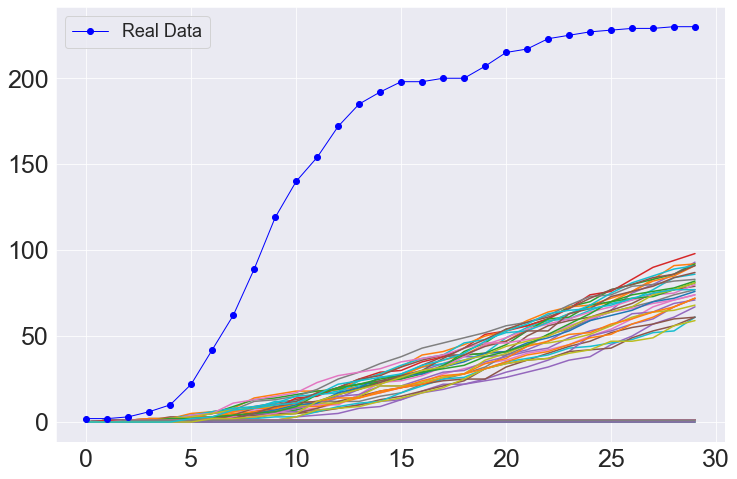

In [87]:
r0 = 12
gamma = 1/14
betae = r0*gamma
betai = r0*gamma*6/4
incubation = 9.5
alpha = 0.13

#*****************可调控参数*********************
#核酸检测窗口
w = 1/3 

#检测力度
p = 0.8

#接触能力
c = 0.02

#静态管控时长
control_time = 300

X0 = np.zeros(len(A))
#seed spreader
X0[60] = 2
# X0[100] = 2
# X0[30] = 2
# # X0[400] = 2
# # X0[459] = 2

#************单次模拟**************#
# S,E,I,Te,R,nX = loop_model(X0,A,incubation,betae,betai,alpha,gamma,p,w,c,control_time)
# fig = plt.figure(figsize=(12,8))

# plt.title('SEITR on Small World, p=0.1, N=500',fontsize = 23)

# plt.plot(S,label = 'Suspectible')
# plt.plot(E,label = 'Exposed')
# plt.plot(I,label = 'Infected')
# plt.plot(Te,label = 'Test Positive')
# plt.plot(R,label = 'Recovered')




# plt.legend(fontsize = 18)
interval = []
fig = plt.figure(figsize=(12,8))
plt.tick_params(labelsize = 25)
#************多次模拟**************#
for ii in range(50):
    S,E,I,Te,R,nX = loop_model(X0,A,incubation,betae,betai,alpha,gamma,p,w,c,control_time)
    plt.plot(Te)
    time = 0
    for jj in range(len(Te)):
            if Te[jj]>18:
                time = jj-1
            if time != 0:
                break
    if time != 0:
        interval.append(time)
data.reset_index(drop=True, inplace=True)
plt.plot(aug_data['累计新增'][:len(Te)],marker='o',lw=1,c='b',label = 'Real Data')
plt.legend(fontsize = 18)

In [88]:
#interval

In [89]:
plt_interval = pd.Series(interval)     

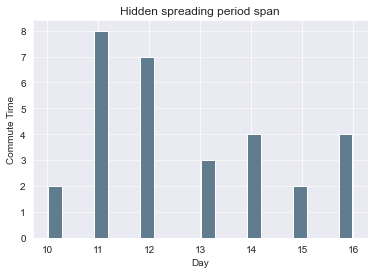

In [90]:
plt_interval.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Hidden spreading period span')
plt.xlabel('Day')
plt.ylabel('Commute Time')
plt.grid(axis='y', alpha=0.75)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

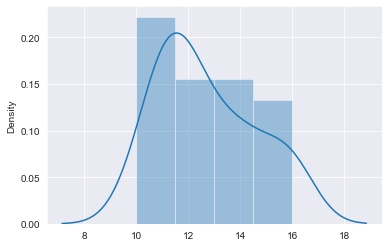

In [91]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(plt_interval)